# Dog Breed Classifier using ResNet50
引用[Kaggle](https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set)上70狗狗種類資料集，以Keras搭建神經網路並對資料進行訓練，訓練後再以測試集輸出預測結果，流程如下：
* 載入資料集
* 導入套件
* 資料前處理
* 以卷積神經網路訓練模組
* 預測並輸出測試結果



## 載入資料集

在colab運行，將資料及上傳至gdive後，使用drive.mount取得路徑與檔案內容





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip '/content/gdrive/My Drive/Deeplearning_project/archive.zip'

串流輸出內容已截斷至最後 5000 行。
  inflating: train/Dhole/085.jpg     
  inflating: train/Dhole/086.jpg     
  inflating: train/Dhole/087.jpg     
  inflating: train/Dhole/088.jpg     
  inflating: train/Dhole/089.jpg     
  inflating: train/Dhole/090.jpg     
  inflating: train/Dhole/091.jpg     
  inflating: train/Dhole/092.jpg     
  inflating: train/Dhole/093.jpg     
  inflating: train/Dhole/094.jpg     
  inflating: train/Dhole/095.jpg     
  inflating: train/Dhole/096.jpg     
  inflating: train/Dhole/097.jpg     
  inflating: train/Dhole/098.jpg     
  inflating: train/Dhole/099.jpg     
  inflating: train/Dhole/100.jpg     
  inflating: train/Dhole/101.jpg     
  inflating: train/Dhole/102.jpg     
  inflating: train/Dhole/103.jpg     
  inflating: train/Dhole/104.jpg     
  inflating: train/Dhole/105.jpg     
  inflating: train/Dhole/106.jpg     
  inflating: train/Dhole/107.jpg     
  inflating: train/Dhole/108.jpg     
  inflating: train/Dhole/109.jpg     
  inflating: train/Dhole/110.

##  導入套件


In [ ]:
#導入必要套件
from builtins import range
import tensorflow as tf
## 若非使用resnet50，則會直接使用sequential配合Conv2D, MaxPool2d以及下列layers方法等等，來搭建CNN
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Model, load_model

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os
import random

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

## 設定參數

In [ ]:
# 設定資料路徑，解壓縮檔案後預設會將檔案逕解壓至當前目錄底下，故僅需設定資料夾名稱就可以代表路徑
train_dir = "train"
valid_dir = "valid"
test_dir = "test"
## 設定預測試的 15 種類別
classList = ["Airedale", "Beagle", "Bloodhound", "Bluetick", "Chihuahua", "Collie", "Dingo", "French Bulldog", "German Sheperd", "Malinois", "Newfoundland", "Pekinese", "Pomeranian", "Pug", "Vizsla"]

## 資料前處理
透過tensorflow.keras.preprocessing.image套件進行影像前處理，使用ImageDataGenerator來格式化資料，並加上classes = classList鎖定15種欲訓練的種類。

In [ ]:
# 影像前處理preprocessing
image_gen = ImageDataGenerator()
train_data_gen = ImageDataGenerator(horizontal_flip = True,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2)

train_data = train_data_gen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = 32,
    class_mode ="categorical",
    classes = classList,  ## 使用自定義classList來限定欲訓練狗狗品種
    shuffle = True
)

valid_data = image_gen.flow_from_directory(
    valid_dir,
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = 32,
    class_mode ="categorical",
    classes = classList,
    shuffle = False
)
test_data = image_gen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = 32,
    class_mode ="categorical",
    classes = classList,
    shuffle = False
)


# 此處用以確定標籤名稱以及對應的索引值
labels = train_data.class_indices
class_mapping = dict((v,k) for k,v in labels.items())
class_mapping

Found 1714 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


{0: 'Airedale',
 1: 'Beagle',
 2: 'Bloodhound',
 3: 'Bluetick',
 4: 'Chihuahua',
 5: 'Collie',
 6: 'Dingo',
 7: 'French Bulldog',
 8: 'German Sheperd',
 9: 'Malinois',
 10: 'Newfoundland',
 11: 'Pekinese',
 12: 'Pomeranian',
 13: 'Pug',
 14: 'Vizsla'}

## 以CNN訓練model
使用ResNet50來訓練，卷積神經網路大致由Conv2D與PoolMax2d組成，最後加上flatten、dropout以及Dense等layer才完成輸出。

In [ ]:
# 使用ResNet50 model
resnetModel = ResNet50(weights="imagenet", include_top=False,
                       input_tensor=Input(shape=(224, 224, 3))) ## 將input設定與前處理時相同

outputs = resnetModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(15, activation="softmax")(outputs)
model = Model(inputs=resnetModel.input, outputs=outputs)

# 設定model
opt = Adam(learning_rate=0.00001)
model.compile(optimizer = opt,
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]
)


model.build(((None, 224, 224, 3)))
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
# model.fit: 訓練 model
train_cb = ModelCheckpoint("model.keras", save_best_only = True) ## 修改過，從./model 改加上.keras
history = model.fit(train_data, validation_data = valid_data, callbacks = [train_cb], epochs = 20, batch_size = 32)

# 使用已知答案的測試集預測資料
batch_size = 32
y_pred = model.predict(test_data, batch_size=batch_size)


# 將訓練完畢的model存擋，可以單獨調用測試其他圖片
tf.keras.models.save_model(model, "model.h5")

Epoch 1/20
54/54 [==============================] - 1246s 23s/step - loss: 3.4304 - accuracy: 0.2170 - val_loss: 1.7077 - val_accuracy: 0.4467
Epoch 2/20
54/54 [==============================] - 1220s 23s/step - loss: 1.8507 - accuracy: 0.4936 - val_loss: 0.8221 - val_accuracy: 0.7400
Epoch 3/20
54/54 [==============================] - 1209s 22s/step - loss: 1.1246 - accuracy: 0.6581 - val_loss: 0.4778 - val_accuracy: 0.8200
Epoch 4/20
54/54 [==============================] - 1223s 23s/step - loss: 0.7677 - accuracy: 0.7649 - val_loss: 0.3542 - val_accuracy: 0.8800
Epoch 5/20
54/54 [==============================] - 1222s 23s/step - loss: 0.6304 - accuracy: 0.8086 - val_loss: 0.2911 - val_accuracy: 0.8667
Epoch 6/20
54/54 [==============================] - 1235s 23s/step - loss: 0.4580 - accuracy: 0.8471 - val_loss: 0.2457 - val_accuracy: 0.9000
Epoch 7/20
54/54 [==============================] - 1251s 23s/step - loss: 0.3670 - accuracy: 0.8804 - val_loss: 0.2070 - val_accuracy: 0.9267

<ipython-input-6-de6b3aeafff7>:11: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, "model.h5")


## 效能評估
以Accuraccy 作為效能評估標準。

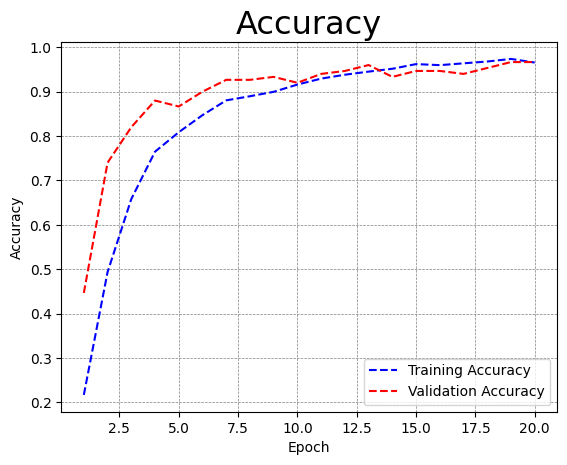

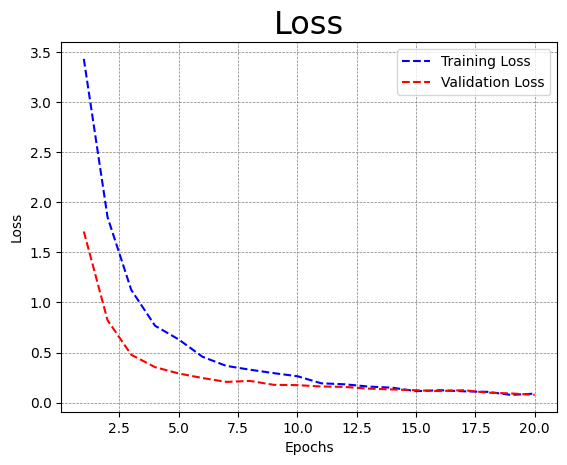

In [ ]:
# 取得訓練時的accuracy資料並印出
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]


epoch_count = range(1, len(val_accuracy) + 1)

plt.plot(epoch_count, accuracy, "b--", label = "Training Accuracy")
plt.plot(epoch_count, val_accuracy, "r--",  label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title('Accuracy',size='23')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show();


# loss
plt.plot(epoch_count, loss, "b--", label = "Training Loss")
plt.plot(epoch_count, val_loss, "r--",  label = "Validation Loss")
plt.xlabel('Epochs');
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss',size='23')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show();


## 預測測試資料並輸出結果
將[Testing set.zip](https://drive.google.com/drive/folders/18-CPmuGVojlaFHuxmz3piv64aC0dQMyd?usp=sharing)輸入測試，並將結果以給定之格式產生outout.xlsx。

In [ ]:
# 預測testing set之資料
## 在gdrive載入資料集
!mkdir 'Testing_set'
!unzip '/content/gdrive/My Drive/Deeplearning_project/Testing set.zip' -d 'Testing_set'
## 載入模組，對測試集進行預測（因一條龍式執行時間過久，難以debug，故以載入方式進行）
test_model = load_model('model.h5')

testData = 'Testing_set'
test_files = os.listdir('Testing_set')
random.shuffle(test_files)

## 建立list放置預測答案
test_results = []

## 受到路徑格式限制，採取迭代方式來對圖片前處理
for file_name in test_files:
    img_path = os.path.join(testData, file_name)
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = img_array.reshape((1,) + img_array.shape)

    ### 進行預測，將結果加入到test_results之中
    predictions = test_model.predict(img_array)
    test_results.append((file_name, classList[predictions.argmax()]))
    print(file_name ,':',classList[predictions.argmax()])

df1 = pd.DataFrame(test_results,
                   columns=["檔名", "結果"])
df1.to_excel("output.xlsx", index = False)

Archive:  /content/gdrive/My Drive/Deeplearning_project/Testing set.zip
  inflating: Testing_set/07JI0uthLSrVgKgQxMSK.jpg  
  inflating: Testing_set/0D69LppfiM6saZx8HnkE.jpg  
  inflating: Testing_set/0Oi1cqNvHD3EMQ5nuy4Z.jpg  
  inflating: Testing_set/18UnlSVe9VZgxRILcnN7.jpg  
  inflating: Testing_set/1jAwfoba7R6KnG35C0nI.jpg  
  inflating: Testing_set/1pzpRRk4PxuAJSq8yTz0.jpg  
  inflating: Testing_set/1UxreplO34TpR3sOKZRe.jpg  
  inflating: Testing_set/1vrolAo8emQSv83VgX1o.jpg  
  inflating: Testing_set/1vvD0WmlqzyjHY42fNWq.jpg  
  inflating: Testing_set/21mKq1h0tio3ISXKraMl.jpg  
  inflating: Testing_set/23gXLPttrkxVXSkC6YPy.jpg  
  inflating: Testing_set/24ujTjneMqCO1DGxC3WI.jpg  
  inflating: Testing_set/25frB1WdoEnZGsyMnwmG.jpg  
  inflating: Testing_set/26WWAlpCvUaJ5JNChxOC.jpg  
  inflating: Testing_set/2gTyvtgGpwsH4tF9iJyZ.jpg  
  inflating: Testing_set/2x8hZwXQ6ek3TNRVUz6r.jpg  
  inflating: Testing_set/3IDymNpmjrHbi8Ll5XvA.jpg  
  inflating: Testing_set/3ZkP9J5Gl9FEaWKjnd6